# Multi-kernel Ridge regression workflow for Neuroscout

Precomputed kernels

### Fetching predictors 

In [1]:
from pyns import Neuroscout

api = Neuroscout()

dataset_name = 'Budapest'

# First run for Budapest dataset
first_run = api.runs.get(dataset_name=dataset_name)[0]
subject = first_run['subject'] # Save subject name

first_run

{'acquisition': None,
 'dataset_id': 27,
 'duration': 535.0,
 'id': 1435,
 'number': 3,
 'session': None,
 'subject': 'sid000005',
 'task': 48,
 'task_name': 'movie'}

In [2]:
mfccs = [f'mfcc_{i}' for i in range(20)]
mel = [f'mel_{i}' for i in range(64)]

confounds = ['']

all_vars = mfccs + mel

Next, we can use the high-level utility `fetch_predictors` to retrieve these predictors for the target subject, rescaled using unit variance, and resampled to the imaging data's Repetition Time (TR):

In [3]:
from pyns.fetch_utils import fetch_predictors

In [4]:
# collection = fetch_predictors(all_vars, dataset_name='Budapest', subject='sid000005', 
#                               resample=True, return_type='collection')

import pickle
# pickle.dump(collection, open('ohbm_results/Budapest_sid000005_mel_mfcc_collection.pkl', 'wb'))
collection = pickle.load(open('ohbm_results/Budapest_sid000005_mel_mfcc_collection.pkl', 'rb'))

This results in a dataframe with predictors, plus meta-data such as file entities (e.g. subjects, runs)

### Fetch fMRI data and loading images


In [5]:
from pyns.fetch_utils import fetch_images

preproc_dir, img_objs = fetch_images('Budapest', '/tmp/', subject=subject, fetch_brain_mask=True)

/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/bids/layout/validation.py:51: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "
/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


action summary:
  get (notneeded: 10)


In [6]:
all_funcs = [f for f in img_objs if f.entities['suffix'] == 'bold']
all_masks = [f for f in img_objs if f.entities['suffix'] == 'mask']

### Image preprocessing

The following computes a joint mask for all runs. Alternatively, we could also provide a apriori ROI mask here.

In [76]:
import nibabel as nib
import numpy as np

def _compute_mask_intersection(masks): 
    """ Compute joint masks (i.e. where all masks have 1s)"""
    _masks = [nib.load(m) for m in masks]
    _data = np.stack(n.get_data() for n in _masks)
    
    intersection = _data.min(axis=0)
    
    mask = nib.Nifti1Image(
        intersection, affine = _masks[0].affine, header=_masks[0].header)
    
    return mask

inter_mask = _compute_mask_intersection(all_masks)

/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_2064769/4205638692.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  _data = np.stack(n.get_data() for n in _masks)


In [90]:
data = inter_mask.get_data()

/tmp/ipykernel_2064769/1945344841.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = inter_mask.get_data(resolution=2)


TypeError: DataobjImage.get_data() got an unexpected keyword argument 'resolution'

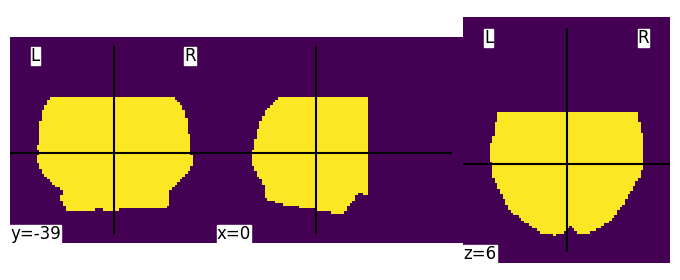

In [114]:
plot_img(inter_mask)

In [115]:
# Mask out frontal cortex to speed up computation
data[:, 57:, :] = 0
data[:, :, 55:] = 0

Now we can apply the corresponding brain mask to each run using `NiftiMasker` from `nilearn`, and stack them into a single array for subsequent analysis

In [117]:
import pandas as pd
import numpy as np
from nilearn.maskers import NiftiMasker

def _mask_and_stack_images(image_objects, mask):
    """ Stack images into single array, and collect metadata entities into dataframe """
    masker = NiftiMasker(mask_img=mask)

    arrays = []
    entities = []
    image_objects = sorted(image_objects, key=lambda x: x.entities['run'])
    for img in image_objects:
        run_y = masker.fit_transform(img)
        arrays.append(run_y)
        entities += [dict(img.entities)] * run_y.shape[0]
    entities = pd.DataFrame(entities)
    return np.vstack(arrays), entities, masker

In [118]:
y, img_entities, masker = _mask_and_stack_images(all_funcs, inter_mask)

In [119]:
y.shape

(3052, 81722)

The following is a generic pipeline for applying the esimator to the data (including support for banded-regression, which we'll discuss later)

Next, we use `Convolve` to apply a `fir` model, and `Scale` to ensure the final predictors have a mean of zero, and finally convert to a pandas df

In [120]:
from bids.modeling.transformations import Convolve, Scale

def _fir_scale_df(collection, predictor_names):    
    Convolve(collection, predictor_names, model='fir', fir_delays=[1, 2, 3, 4])
    
    all_vars = list(collection.variables.keys())
    
    Scale(collection, predictor_names, demean=True, rescale=False)

    # To df, and sort rows by keys
    collection_df = collection.to_df().sort_values(['subject', 'run', 'onset'])

    # Reorder columns
    sort_columns = ['onset', 'duration'] + predictor_names
    sort_columns += collection_df.columns.difference(sort_columns).tolist()
    collection_df = collection_df[sort_columns]
    
    return collection_df

collection_df = _fir_scale_df(collection, all_vars)

In [189]:
collection_df.columns.str.startswith('mfcc').sum()

100

In [190]:
collection_df.columns.str.startswith('mel').sum()

320

### Banded model with both mel and MFCC & split scoring

In [121]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV
from sklearn.model_selection import GroupKFold
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend


groups = collection_df['run'].tolist()
n_runs = len(set(groups))
cv = GroupKFold(n_splits=n_runs)
inner_cv = GroupKFold(n_splits=n_runs - 1)

In [122]:
y.shape

(3052, 81722)

In [158]:
from himalaya.kernel_ridge import Kernelizer
from himalaya.kernel_ridge import ColumnKernelizer
from sklearn.pipeline import make_pipeline

def _model_cv_banded(estimator, cv, X, y, bands=None, groups=None,
              kernel='linear',
              inner_cv=None):
    
    backend = set_backend("torch_cuda", on_error="warn")
    
    # Container for results
    results = {
        'coefficients': [],
        'test_predictions': [],
        'test_split_predictions': [],
        'split_scores': [],
        'corr_scores': []
    }
    
                        
    # Extract number of samples for convenience
    n_samples = y.shape[0]
    
    # Loop through outer cross-validation folds
    for ix, (train, test) in enumerate(cv.split(np.arange(n_samples), groups=groups)):
        
        # Run only one loop for testing
        if ix > 0:
            break
        
        # Get training model for list of model bands
        X_train = X[train]
        Y_train = y[train]
        
        X_test = X[test]
        Y_test = y[test]
        
                  
        # Demean Y over samples
        Y_train -= Y_train.mean(0)
        Y_test -= Y_test.mean(0)
        
        # Create inner cross-validation loop if specified
        if inner_cv:
            # Split inner cross-validation with groups if supplied
            inner_groups = np.array(groups)[train] if groups else groups
            inner_splits = inner_cv.split(np.arange(n_samples)[train],
                                          groups=inner_groups)
            
            # Update estimator with inner cross-validator
            estimator.set_params(cv=inner_splits)

        # Define kernalizer pipeline
        kernelizers_tuples = []
        for i, b_ix in enumerate(bands):
            kernelizers_tuples.append((f"kernel_{i}", Kernelizer(kernel="linear"), b_ix))
        column_kernelizer = ColumnKernelizer(kernelizers_tuples)
    
        pipeline = make_pipeline(
            column_kernelizer,
            estimator,
        )

        # Fit the regression model on training data
        pipeline.fit(X_train, Y_train)
        
#         # Zero out coefficients for confounds if provided
#         if confounds is not None:
#             estimator.coef_[-len(confounds):] = 0
        
        # Compute predictions with splitting by band
        test_prediction_ = pipeline.predict(X_test, split=True)
        
        # Perform split scoring
        scores_ = r2_score_split(Y_test, test_prediction_)
        scores = backend.to_numpy(scores_)
        test_prediction = backend.to_numpy(test_prediction_)
        del(scores_)
        del(test_prediction_)
        
        results['split_scores'].append(scores)
        results['test_split_predictions'].append(test_prediction)
        
        # Perform standard scoring
        test_prediction0_ = pipeline.predict(X_test)
        
        scores0_ = correlation_score(Y_test, test_prediction0_)
        scores0 = backend.to_numpy(scores0_)
        test_prediction0 = backend.to_numpy(test_prediction0_)
        del(scores0_)
        del(test_prediction0_)
        
        results['corr_scores'].append(scores0)
        results['test_predictions'].append(test_prediction0)

        # Populate results dictionary
#         results['coefficients'].append(estimator.dual_coef_)
    
        del(pipeline)
        
    # Combine into single aray
#     results['coefficients'] = np.stack(results['coefficients'])
    results['split_scores'] = np.stack(results['split_scores'])
    results['corr_scores'] = np.stack(results['corr_scores'])

    return results

In [154]:
n_iter = 20

alphas = np.logspace(1, 20, 10)

n_targets_batch = 200
n_alphas_batch = 5
n_targets_batch_refit = 200

solver = "random_search"

solver_params = dict(n_iter=n_iter, alphas=alphas,
                     n_targets_batch=n_targets_batch,
                     n_alphas_batch=n_alphas_batch,
                     n_targets_batch_refit=n_targets_batch_refit)

mkr_model = MultipleKernelRidgeCV(kernels="precomputed", solver=solver,
                                  solver_params=solver_params)

In [ ]:
from himalaya.scoring import r2_score_split

X = collection_df.iloc[:, collection_df.columns.str.startswith('m')]

# Names of bandsb
bands = [X.columns.str.startswith('mfcc'), X.columns.str.startswith('mel')] 

In [155]:
result_combined_split = _model_cv_banded(mkr_model, cv, X.values, y, inner_cv=inner_cv, bands=bands, 
                                         groups=groups, kernel='linear')

[                                        ] 0% | 0.00 sec | 20 random sampling with cv | 

KeyboardInterrupt: 

In [127]:
result_combined_split

{'coefficients': [],
 'test_predictions': [array([[ 1.22519965e-15, -2.43011734e-14, -1.39457143e-14, ...,
           7.51066864e-15, -4.07131265e-14, -3.15428467e-14],
         [ 1.22531487e-15, -2.43014425e-14, -1.39459609e-14, ...,
           7.51089055e-15, -4.07139896e-14, -3.15435763e-14],
         [ 1.22513802e-15, -2.43013497e-14, -1.39457212e-14, ...,
           7.51055322e-15, -4.07132784e-14, -3.15428322e-14],
         ...,
         [ 1.22529742e-15, -2.43013069e-14, -1.39455198e-14, ...,
           7.51061413e-15, -4.07130982e-14, -3.15428471e-14],
         [ 1.22517035e-15, -2.43013512e-14, -1.39458439e-14, ...,
           7.51064337e-15, -4.07134598e-14, -3.15430504e-14],
         [ 1.22520977e-15, -2.43012979e-14, -1.39457658e-14, ...,
           7.51066992e-15, -4.07133837e-14, -3.15430152e-14]]),
  array([[-2.52052032e-14, -3.82588607e-14,  1.41293473e-14, ...,
          -1.36835838e-14, -4.91260677e-14, -6.56718142e-14],
         [-2.52079965e-14, -3.82636585e-14,  1.

In [128]:
mean_scores = result_combined_split['split_scores'].mean(axis=0)

In [138]:
corr_scores = result_combined_split['corr_scores'].mean(axis=0)

In [129]:
from nilearn.plotting import plot_stat_map, plot_img

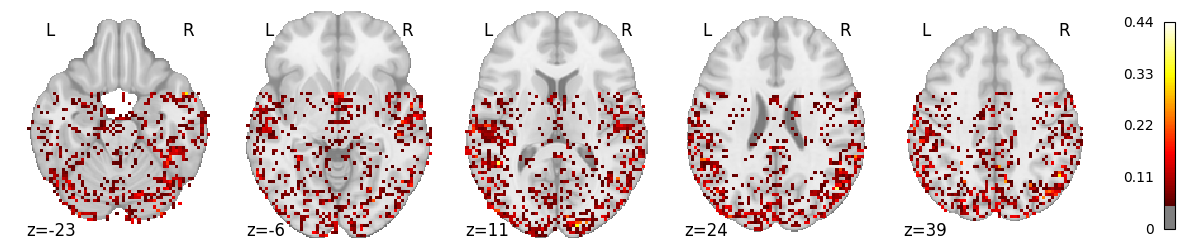

In [192]:
corr_scores[corr_scores < 0] = 0
plot_stat_map(masker.inverse_transform(corr_scores), display_mode='z', cut_coords=[-23, -6, 11, 24, 39], threshold=0.05)

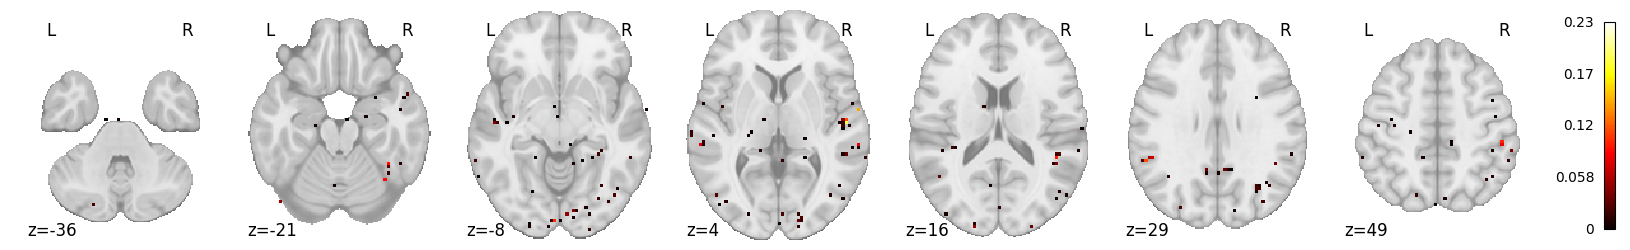

In [145]:
m0 = mean_scores[0]
m0[m0 < 0] = 0
plot_stat_map(masker.inverse_transform(m0), display_mode='z', vmax=0.23)

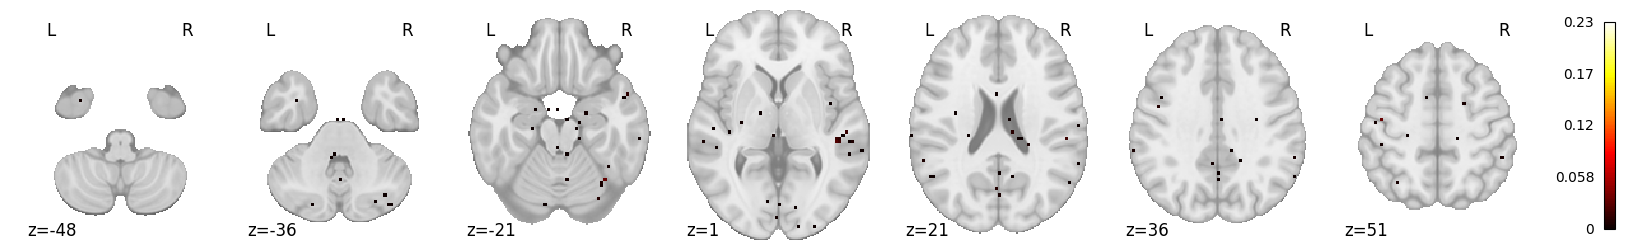

In [147]:
m1 = mean_scores[1]
m1[m1 < 0] = 0
plot_stat_map(masker.inverse_transform(m1), display_mode='z', vmax=0.23)

### Test on one run

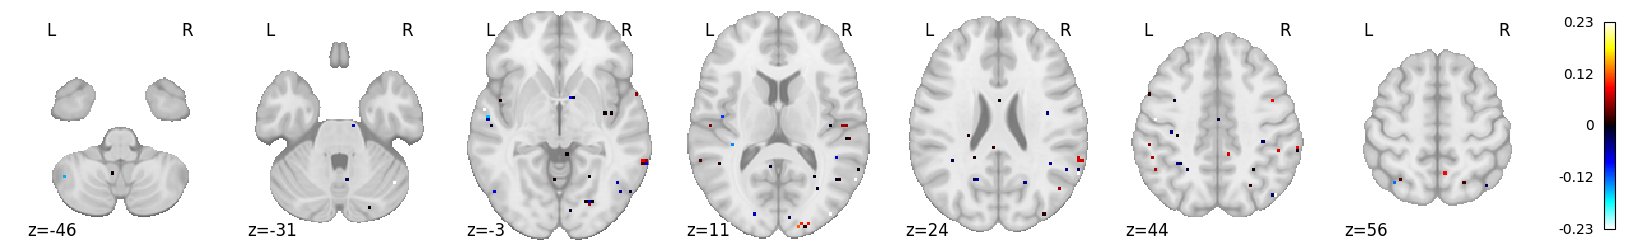

In [183]:
plot_stat_map(masker.inverse_transform(result_combined_split['split_scores'][0][0]
), display_mode='z', vmax=0.23)

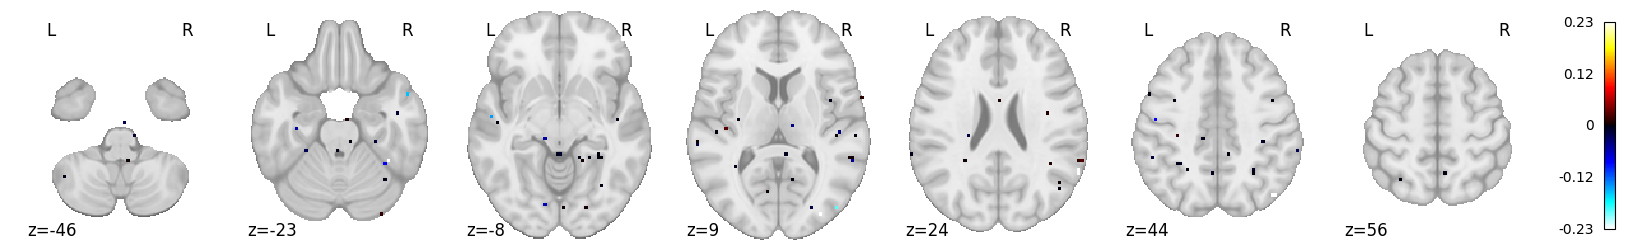

In [184]:
plot_stat_map(masker.inverse_transform(result_combined_split['split_scores'][0][1]
), display_mode='z', vmax=0.23)